In [103]:
# %reload_ext autoreload
# %autoreload 1   
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import CNN_utils
import imp
imp.reload(CNN_utils)
from CNN_utils import CNN_net

import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

EPOCHS = 100
BATCH_SIZE = 4
LEARNING_RATE = 0.01


cuda


In [96]:
TRAIN_DATA_PATH = "./cnn_data/train"
TEST_DATA_PATH = "./cnn_data/test"
TRANSFORM_IMG = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader=test_loader

classes=list(train_data.class_to_idx.keys()) #get list of classes

In [97]:
#io calculator
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    print(output)
    return(output)
#get all targets


In [100]:
# let's get the weight of the samples incase we want to make a weighted
# sampler to deal with data imbalance
# # expensive to compute so commented
targets=[]
for batch_idx, (d, l) in enumerate(train_loader):
    targets.extend(list(l.numpy()))
# Compute samples weight (each sample should get its own weight)
target=torch.tensor(targets)
class_sample_count = torch.tensor(
    [(target == t).sum() for t in torch.unique(target, sorted=True)])
weight = 1. / class_sample_count.float()
samples_weight = torch.tensor([weight[t] for t in target])
print("here are the weights to account for class sizes")
print(dict(zip(classes,list(weight.numpy()*1000))))

here are the weights to account for class sizes
{'clap': 1.8621974, 'guitar': 2.2421527, 'hat': 0.61576355, 'kick': 0.6455778, 'piano': 2.5062656, 'rim': 3.1746032, 'shake': 8.77193, 'snare': 0.47641733, 'stack': 0.32499188}


In [101]:
def trainCNN(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    n_batches = len(train_loader)
# weight=samples_weight.to(device)
    loss = torch.nn.CrossEntropyLoss(weight=weight.to(device))    
    optimizer = optim.Adadelta(net.parameters(),learning_rate)
    
    #get time
    training_start_time = time.time()    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            #inputs, labels = data
            inputs, labels =  data[0].to(device), data[1].to(device)
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 20th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels =  inputs.to(device), labels.to(device)
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "./models/model-%s-%s.states"%(BATCH_SIZE,epoch))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [27]:
import time

def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
#     train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
#             inputs, labels = data[0], data[1]
            inputs, labels = data[0].to(device), data[1].to(device)
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data
            total_train_loss += loss_size.data
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [102]:
# CNN = CNN_net()
CNN.to(device)
trainCNN(CNN, batch_size=32, n_epochs=5, learning_rate=0.1)

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 20
learning_rate= 0.1
Epoch 1, 10% 	 train_loss: 1.86 took: 1.13s
Epoch 1, 20% 	 train_loss: 1.38 took: 1.02s
Epoch 1, 30% 	 train_loss: 1.10 took: 1.10s
Epoch 1, 40% 	 train_loss: 1.02 took: 1.14s
Epoch 1, 50% 	 train_loss: 0.84 took: 1.15s
Epoch 1, 60% 	 train_loss: 0.83 took: 1.15s
Epoch 1, 70% 	 train_loss: 0.85 took: 1.15s
Epoch 1, 80% 	 train_loss: 0.82 took: 1.08s
Epoch 1, 90% 	 train_loss: 0.75 took: 1.12s
Validation loss = 0.73
Epoch 2, 10% 	 train_loss: 0.70 took: 1.23s
Epoch 2, 20% 	 train_loss: 0.63 took: 1.14s
Epoch 2, 30% 	 train_loss: 0.66 took: 1.15s
Epoch 2, 40% 	 train_loss: 0.71 took: 1.14s
Epoch 2, 50% 	 train_loss: 0.69 took: 1.14s
Epoch 2, 60% 	 train_loss: 0.60 took: 1.12s
Epoch 2, 70% 	 train_loss: 0.59 took: 1.10s
Epoch 2, 80% 	 train_loss: 0.63 took: 1.14s
Epoch 2, 90% 	 train_loss: 0.70 took: 1.15s
Validation loss = 0.60
Epoch 3, 10% 	 train_loss: 0.59 took: 1.25s
Epoch 3, 20% 	 train_loss: 0.61 took: 1.15s
E

In [124]:
s=torch.load("models/model-4-18.states")
cnn = CNN_utils.CNN_net()
cnn.load_state_dict(s["model_state_dict"])
# cnn.to(device)
cnn.to("cpu")

CNN_net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


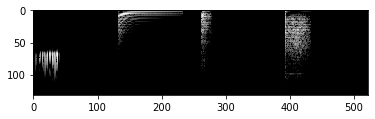

GroundTruth:  stack         kick          hat          hat
Predicted:    stack         kick          hat          hat


In [125]:
dataiter = iter(test_loader)
# functions to show an image
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '        '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))
dimg=images.to(device)
outputs=CNN(dimg)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', '        '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))

In [126]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 91 %


In [127]:
class_correct = list(0. for i in range(19))
class_total = list(0. for i in range(19))

with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            try:
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            except:
                continue

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  clap : 85 %
Accuracy of guitar : 95 %
Accuracy of   hat : 92 %
Accuracy of  kick : 95 %
Accuracy of piano : 70 %
Accuracy of   rim : 66 %
Accuracy of shake : 50 %
Accuracy of snare : 91 %
Accuracy of stack : 95 %


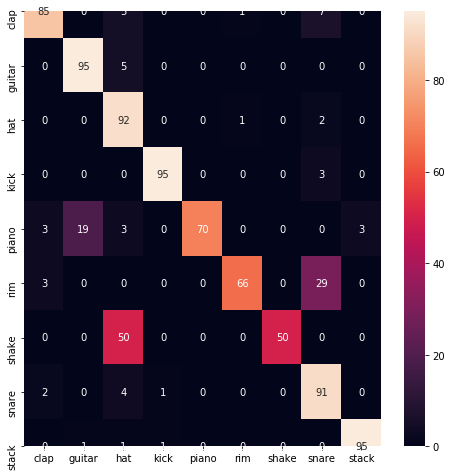

In [130]:
## making a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

predictions=[]
l=[]
with torch.no_grad():
    for data in test_loader:
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        l.extend(labels.cpu().numpy())
cm=confusion_matrix(l,predictions)

# normalize confusion matrix per class
for i,c in enumerate(cm):
    cm[i]=c/sum(c)*100


df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (8,8))
sn.heatmap(df_cm, annot=True)
